# Jumba Demo 002

## Fibonacci Series

Lets try with Fibonacci the popular Fibonacci series:

$$f(n) = \begin{cases}
         0               & n = 0\\
         1               & n = 1\\
         f(n-1) + f(n-2) & n > 1
         \end{cases}$$
         
It's quite easy.

In [1]:
def fibonacci_n(x):
    assert x >= 0
    
    if x <= 1:
        return x
        
    return fibonacci_n(x - 1) + fibonacci_n(x - 2)

print(' '.join(str(fibonacci_n(x))
               for x in range(10)) + '...')

0 1 1 2 3 5 8 13 21 34...


But it is super inefficient with:

$$O(n) = 2^{X-2}$$

Lets convert it to an iteractive function by memoizing former results at each iteration:

In [2]:
def fibonacci_i(x):
    assert x >= 0
    
    if x <= 1:
        return x
    
    y2 = 0
    y1 = 1
    y = 0
    for n in range(x - 1):
        y = y1 + y2
        y1, y2 = y, y1
        
    return y
        
print(' '.join(str(fibonacci_i(x))
               for x in range(10)) + '...')

0 1 1 2 3 5 8 13 21 34...


Lets define a benchmark and use it to compare the two functions:

In [3]:
from IPython.display import display
from itertools import combinations
import time
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

def run_benchmarks(minX, maxX, step=1, num_runs=10, funs=None):
    assert funs, 'Please pass a sequence of functions to be tested'
    assert num_runs, 'Number of runs must be strictly positive'
    
    def _measure(x, fun):
        start = time.time()
        for i in range(num_runs):
            fun(x)
        return (time.time() - start) / num_runs
    
    df = pd.DataFrame()
    for fun in funs:
        fun(minX)  # This is necessary to let JIT produce the native function.
        XX = [x
              for x in range(minX, maxX + 1, step)]
        YY = [_measure(x, fun) for x in XX]
        df[fun.__name__] = pd.Series(data=YY,
                                     index=XX,
                                     name=fun.__name__)
    plt.figure()
    df.plot(figsize=(10,5),
            title='$y=Log_{10}(T(f(x)))$',
            logy=True)
    
    if len(funs) >= 2:
        comb = combinations(((fun.__name__,
                              df[fun.__name__].values)
                             for fun in funs), 2)
        for (funA, timesA), (funB, timesB) in comb:
            title = '$y=\\frac{T(%s(x))}{T(%s(x))}$' % (funA, funB)
            ratios = df[funA] / df[funB]
            plt.figure()
            ratios.plot(figsize=(10,5),
                        title=title)

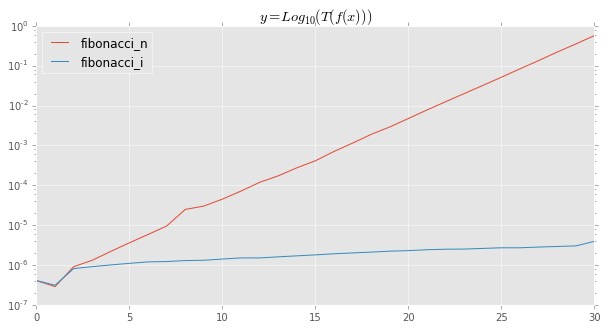

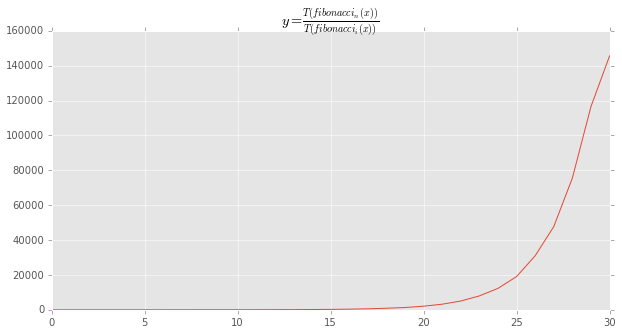

In [4]:
run_benchmarks(0, 30,
               funs=[fibonacci_n, fibonacci_i])

The iterative aproach, being linear, is already hundred thousand times faster for $x=30$

Lets try to apply JIT optimizations on both implementations:

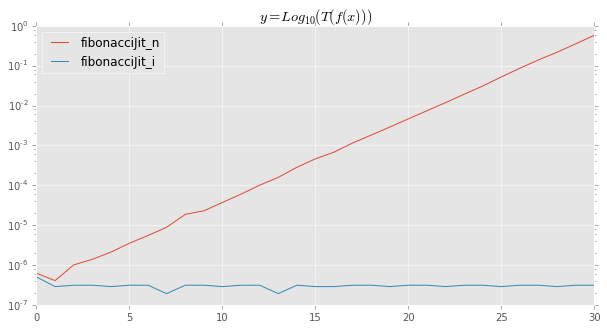

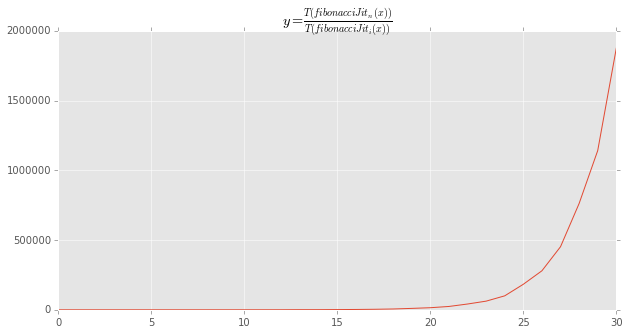

In [5]:
from numba import jit

@jit
def fibonacciJit_n(x):
    assert x >= 0
    
    if x <= 1:
        return x
        
    return fibonacci_n(x - 1) + fibonacci_n(x - 2)

@jit
def fibonacciJit_i(x):
    assert x >= 0
    
    if x <= 1:
        return x
    
    y2 = 0
    y1 = 1
    y = 0
    for n in range(x - 1):
        y = y1 + y2
        y1, y2 = y, y1
        
    return y

run_benchmarks(0, 30,
               funs=[fibonacciJit_n, fibonacciJit_i])

The same thing, but how much JIT improves performances of our `fibonacci_i` implementations?

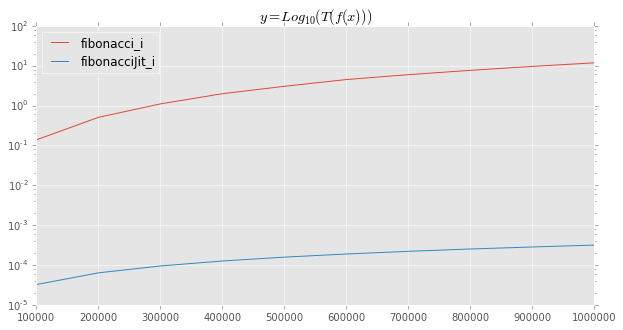

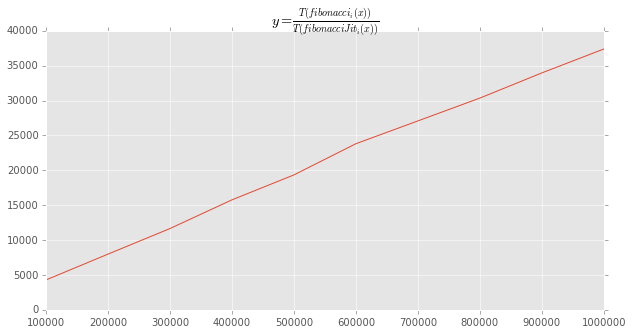

In [6]:
run_benchmarks(100000, 1000000,
               step=100000,
               num_runs=3,
               funs=[fibonacci_i, fibonacciJit_i])

WoW, JIT makes our iterative implementation thousands times faster!

But why the performance ratio is not constant?

Is it because of memory allocations pure Python implementation does into the internal loops?